In [10]:
using MAT, Plots, LinearAlgebra, Statistics

In [3]:
f_idx = matopen("D_IDX_SP_Phantom2025.mat")
idx = read(f_idx, "idx")
close(f_idx)

f_dict = matopen("D_Phantom2025_invEff096_SPinf_norefocusingTEadj_576InvTime_1000RF_10mm_101iso_0.mat")
dict_epg = read(f_dict, "dict0")
close(f_dict)

sampled_pairs_ms = [(row[1], row[2]) for row in eachrow(idx)]
sampled_pairs_s  = [(T1 / 1000, T2 / 1000) for (T1, T2) in sampled_pairs_ms]

5865-element Vector{Tuple{Float32, Float32}}:
 (0.1, 0.01)
 (0.12, 0.01)
 (0.14, 0.01)
 (0.16, 0.01)
 (0.18, 0.01)
 (0.2, 0.01)
 (0.22, 0.01)
 (0.24, 0.01)
 (0.26, 0.01)
 (0.28, 0.01)
 ⋮
 (2.2, 1.5)
 (2.3, 1.5)
 (2.4, 1.5)
 (2.5, 1.5)
 (2.6, 1.5)
 (2.7, 1.5)
 (2.8, 1.5)
 (2.9, 1.5)
 (3.0, 1.5)

In [4]:
epg_dict = Dict{Tuple{Int, Int}, Vector{Float64}}()

for (T1, T2) in sampled_pairs_ms
    i = findfirst(j -> idx[j, 1] == T1 && idx[j, 2] == T2, 1:size(idx, 1))

    signal = abs.(dict_epg[:, i])
    signal ./= norm(signal)

    epg_dict[(T1, T2)] = signal
end

In [6]:
# --- Load Bloch dictionary ---
bloch_data = matread("bloch_dict_5mm.mat")
dict0_bloch = bloch_data["dict0"]
idx_bloch = bloch_data["idx"]


# Create Bloch dictionary lookup
bloch_dict = Dict{Tuple{Int, Int}, Vector{Float64}}()
for j in 1:size(idx_bloch, 1)
    key = Tuple(Int.(idx_bloch[j, :]))
    sig = vec(dict0_bloch[:, j])
    bloch_dict[key] = sig ./ norm(sig)
end

In [7]:
# --- Compare shared keys ---
shared_keys = intersect(keys(bloch_dict), keys(epg_dict))

errors = Dict{Tuple{Int, Int}, Float64}()

for key in shared_keys
    sig_epg = epg_dict[key]
    sig_bloch = bloch_dict[key]
    err = norm(sig_epg - sig_bloch)
    errors[key] = err
end

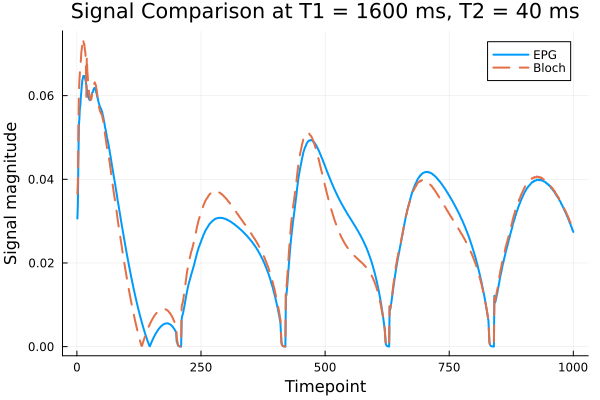

In [8]:
# --- Plot a sample ---
sample_key = first(shared_keys)
plot(abs.(epg_dict[sample_key]), label="EPG", linewidth=2)
plot!(abs.(bloch_dict[sample_key]), label="Bloch", linestyle=:dash, linewidth=2)
title!("Signal Comparison at T1 = $(sample_key[1]) ms, T2 = $(sample_key[2]) ms")
xlabel!("Timepoint")
ylabel!("Signal magnitude")

In [11]:
# --- Print error summary ---
mean_error = mean(values(errors))
max_error = maximum(values(errors))
@info "Compared $(length(shared_keys)) signals"
@info "Mean L2 error: $mean_error"
@info "Max L2 error: $max_error"

┌ Info: Compared 5865 signals
└ @ Main c:\Users\lucya\MSC_PROJECT\Dictionary\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X14sZmlsZQ==.jl:4
┌ Info: Mean L2 error: 0.08021764562656389
└ @ Main c:\Users\lucya\MSC_PROJECT\Dictionary\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X14sZmlsZQ==.jl:5
┌ Info: Max L2 error: 0.24549833979730806
└ @ Main c:\Users\lucya\MSC_PROJECT\Dictionary\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X14sZmlsZQ==.jl:6


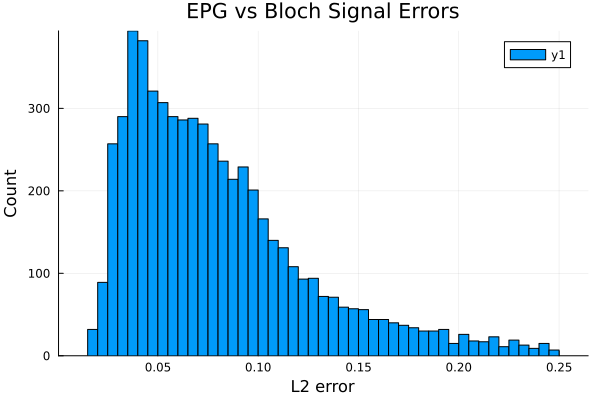

In [12]:
histogram(collect(values(errors)), bins=50, title="EPG vs Bloch Signal Errors", xlabel="L2 error", ylabel="Count")
